## 1. Imports <a name="1"></a>
<hr>

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz

%matplotlib inline

<br><br>

## 2. Data and processing <a name="2"></a>
<hr>

In [2]:
spotify_df = pd.read_csv("SpotifyFeatures.csv")
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


I'm cleaning up the CSV a bit. In particular, 

1. I'm changing popularity of 0 to 1 to avoid divide by zero errors latter. Note that the popularity ranges from 0 to 100, with 0 being least popular and 100 being most popular. So changing the popularity from 0 to 1 should not make a huge difference.
2. Seems like the genre feature has two slightly different versions of the category Children's Music with two different quotation marks (` and '). I'm mapping them both to "Children's Music".  

In [3]:
spotify_df.loc[spotify_df["popularity"] == 0, "popularity"] = 1

In [4]:
spotify_df["genre"].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

In [5]:
spotify_df.loc[spotify_df["genre"] == "Children’s Music", "genre"] = "Children's Music"

This dataset is large and in this lab we want to explore ensemble methods which can be computationally intensive. So when we split the data, I am putting most of the data in the test split. If your computer can handle it, you are welcome to experiment with a bigger training split. 

In [6]:
spotify_df.shape

(232725, 18)

In [7]:
train_df, test_df = train_test_split(spotify_df, test_size=0.97, random_state=123)

In [8]:
train_df.shape

(6981, 18)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6981 entries, 57856 to 15725
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             6981 non-null   object 
 1   artist_name       6981 non-null   object 
 2   track_name        6981 non-null   object 
 3   track_id          6981 non-null   object 
 4   popularity        6981 non-null   int64  
 5   acousticness      6981 non-null   float64
 6   danceability      6981 non-null   float64
 7   duration_ms       6981 non-null   int64  
 8   energy            6981 non-null   float64
 9   instrumentalness  6981 non-null   float64
 10  key               6981 non-null   object 
 11  liveness          6981 non-null   float64
 12  loudness          6981 non-null   float64
 13  mode              6981 non-null   object 
 14  speechiness       6981 non-null   float64
 15  tempo             6981 non-null   float64
 16  time_signature    6981 non-null   obj

I am defining different feature types and a couple of preprocessors below.  

In [10]:
# Define feature types.

drop_features = ["track_id", "artist_name"]
binary_features = ["mode"]
categorical_features = ["genre", "time_signature", "key"]
text_feature = "track_name"
target = "popularity"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [text_feature]
    + [target]
)

In [11]:
# Define preprocessors

preprocessor_num_bin = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    ("drop", drop_features),
)  # preprocessor which includes only numeric and binary features

In [12]:
preprocessor_all = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (CountVectorizer(stop_words="english", max_features=100), text_feature),
    ("drop", drop_features),
)  # preprocessor which includes all features

In [13]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [14]:
preprocessor_num_bin.fit(X_train)
preprocessor_all.fit(X_train);

OK. Seems like both preprocessors are working OK. 

<br><br>

### 2.1 EDA

In [15]:
cor = train_df.corr()
cor

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
popularity,1.000000,-0.382900,0.245030,0.004289,0.254626,-0.212365,-0.151185,0.363156,-0.137286,0.094807,0.045311
acousticness,-0.382900,1.000000,-0.357658,-0.008838,-0.725823,0.325105,0.062738,-0.685641,0.146280,-0.235088,-0.313770
danceability,0.245030,-0.357658,1.000000,-0.124553,0.317064,-0.375560,-0.051150,0.433079,0.150332,0.038445,0.557092
duration_ms,0.004289,-0.008838,-0.124553,1.000000,-0.010738,0.048705,0.038517,-0.030150,-0.017471,-0.023717,-0.159619
energy,0.254626,-0.725823,0.317064,-0.010738,1.000000,-0.392617,0.197124,0.814222,0.148422,0.229056,0.425668
instrumentalness,-0.212365,0.325105,-0.375560,0.048705,-0.392617,1.000000,-0.135068,-0.516023,-0.179504,-0.118903,-0.317376
liveness,-0.151185,0.062738,-0.051150,0.038517,0.197124,-0.135068,1.000000,0.048318,0.498724,-0.042219,0.012552
loudness,0.363156,-0.685641,0.433079,-0.030150,0.814222,-0.516023,0.048318,1.000000,0.009731,0.234704,0.395774
speechiness,-0.137286,0.146280,0.150332,-0.017471,0.148422,-0.179504,0.498724,0.009731,1.000000,-0.070959,0.025440
tempo,0.094807,-0.235088,0.038445,-0.023717,0.229056,-0.118903,-0.042219,0.234704,-0.070959,1.000000,0.143141


In [22]:
possibly_most_relevant = [
    "loudness",
    "energy",
    "danceability",
    "valence",
    "popularity",
    "tempo",
    "instrumentalness",
    "speechiness"
]
 
cor = train_df[possibly_most_relevant].corr()
cor

,loudness,energy,danceability,valence,popularity,tempo,instrumentalness,speechiness
loudness,1.000000,0.814222,0.433079,0.395774,0.363156,0.234704,-0.516023,0.009731
energy,0.814222,1.000000,0.317064,0.425668,0.254626,0.229056,-0.392617,0.148422
danceability,0.433079,0.317064,1.000000,0.557092,0.245030,0.038445,-0.375560,0.150332
valence,0.395774,0.425668,0.557092,1.000000,0.045311,0.143141,-0.317376,0.025440
popularity,0.363156,0.254626,0.245030,0.045311,1.000000,0.094807,-0.212365,-0.137286
tempo,0.234704,0.229056,0.038445,0.143141,0.094807,1.000000,-0.118903,-0.070959
instrumentalness,-0.516023,-0.392617,-0.375560,-0.317376,-0.212365,-0.118903,1.000000,-0.179504
speechiness,0.009731,0.148422,0.150332,0.025440,-0.137286,-0.070959,-0.179504,1.000000


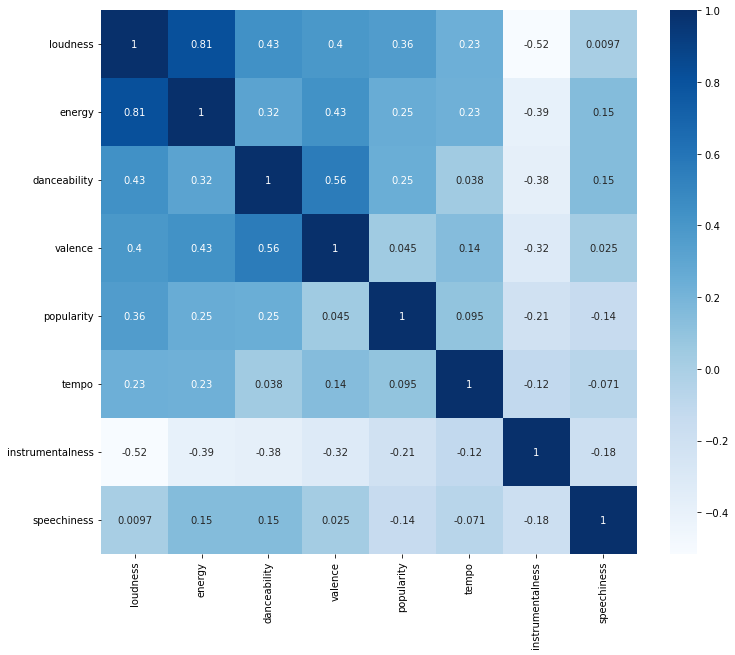

In [23]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

The loudness and erengy are likly positively correlated, since the correlation is 0.81 whichis close to 1. others are likely no or less linear trend between every pairs of features. The feature Acousticness is likely nagetively correlated to the features.

<br><br>

## 3. Ensembles  <a name="3"></a>
<hr>

### 3.1 Baseline Model: Dummy Regressor

In [39]:
from sklearn.metrics import make_scorer


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [40]:
results = {}

In [41]:
# Validation function.

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [42]:
# Print baseline model results.

dummy = DummyRegressor()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

,Dummy
fit_time,0.003 (+/- 0.001)
score_time,0.002 (+/- 0.001)
test_neg RMSE,-18.105 (+/- 0.329)
train_neg RMSE,-18.102 (+/- 0.083)
test_r2,-0.002 (+/- 0.001)
train_r2,0.000 (+/- 0.000)
test_mape,-193.549 (+/- 16.812)
train_mape,-193.505 (+/- 3.874)


<br><br>

### 3.2 Different models 

Using different models:
- ridge
- random forest
- XGBoost
- LightGBM
- CatBoost

In [43]:
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBRegressor

pipe_rid = make_pipeline(preprocessor_num_bin, Ridge(random_state=123))
pipe_rf = make_pipeline(preprocessor_num_bin, RandomForestRegressor(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor_num_bin, XGBRegressor(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor_num_bin, LGBMRegressor(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor_num_bin, CatBoostRegressor(random_state=123, verbose=0)
)
models = {
    "ridge": pipe_rid,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [44]:
models

{'ridge': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('standardscaler',
                                                   StandardScaler(),
                                                   ['valence', 'speechiness',
                                                    'tempo', 'instrumentalness',
                                                    'acousticness',
                                                    'duration_ms', 'liveness',
                                                    'danceability', 'energy',
                                                    'loudness']),
                                                  ('onehotencoder',
                                                   OneHotEncoder(drop='if_binary',
                                                                 dtype='int'),
                                                   ['mode']),
                                                  ('drop', 'drop',
     

In [46]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.038 (+/- 0.033),0.025 (+/- 0.027),-15.873 (+/- 0.327),-15.840 (+/- 0.081),0.230 (+/- 0.021),0.234 (+/- 0.005),-161.321 (+/- 13.786),-160.987 (+/- 3.134)
random forest,4.187 (+/- 0.041),0.043 (+/- 0.001),-14.813 (+/- 0.414),-5.571 (+/- 0.055),0.329 (+/- 0.027),0.905 (+/- 0.002),-137.900 (+/- 15.621),-50.632 (+/- 1.716)
XGBoost,0.720 (+/- 0.006),0.010 (+/- 0.000),-15.654 (+/- 0.355),-6.709 (+/- 0.210),0.251 (+/- 0.031),0.862 (+/- 0.010),-135.043 (+/- 16.195),-45.715 (+/- 1.986)
LightGBM,0.114 (+/- 0.001),0.012 (+/- 0.000),-14.939 (+/- 0.448),-10.917 (+/- 0.058),0.318 (+/- 0.031),0.636 (+/- 0.003),-135.424 (+/- 17.275),-92.692 (+/- 2.571)
CatBoost,2.732 (+/- 0.467),0.010 (+/- 0.002),-14.906 (+/- 0.337),-9.829 (+/- 0.116),0.321 (+/- 0.023),0.705 (+/- 0.006),-133.988 (+/- 15.170),-77.618 (+/- 2.485)


<br><br>

### 3.3 Analysis 

##### 1. Best and worst performing models 
With default hyperparameters for all models, the `random forest` model seems to be performing best, whereas `Ridge` seem to be performing worst.  

##### 2. Overfitting/underfitting
`Ridge` seems to underfit; the training score is low and the gap between train and validation score is not that big compared to other models.

All tree-based models seem to overfit; training scores are high but validation scores are much lower than that. `LightGBM` and `CatBoost` seem to overtfit less. 

##### 3. Fit time
Although `random forest` gives us the best scores, it is much slower than other models. For instance, the *fit* time for the random forest is a lot slower than `LightGBM`. Also, the `ridge` is the fastest model with the lowest fit time among all the models.

##### 4. Score time
Scoring is fast for almost all models (around 0.01s)except `random forests` (around 0.04s).


<br><br>

### 3.4 Voting regressor 

In [49]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

averaging_model = VotingRegressor(list(models.items()), n_jobs=-1)

In [51]:
results["voting"] = mean_std_cross_val_scores(
    averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.038 (+/- 0.033),0.025 (+/- 0.027),-15.873 (+/- 0.327),-15.840 (+/- 0.081),0.230 (+/- 0.021),0.234 (+/- 0.005),-161.321 (+/- 13.786),-160.987 (+/- 3.134)
random forest,4.187 (+/- 0.041),0.043 (+/- 0.001),-14.813 (+/- 0.414),-5.571 (+/- 0.055),0.329 (+/- 0.027),0.905 (+/- 0.002),-137.900 (+/- 15.621),-50.632 (+/- 1.716)
XGBoost,0.720 (+/- 0.006),0.010 (+/- 0.000),-15.654 (+/- 0.355),-6.709 (+/- 0.210),0.251 (+/- 0.031),0.862 (+/- 0.010),-135.043 (+/- 16.195),-45.715 (+/- 1.986)
LightGBM,0.114 (+/- 0.001),0.012 (+/- 0.000),-14.939 (+/- 0.448),-10.917 (+/- 0.058),0.318 (+/- 0.031),0.636 (+/- 0.003),-135.424 (+/- 17.275),-92.692 (+/- 2.571)
CatBoost,2.732 (+/- 0.467),0.010 (+/- 0.002),-14.906 (+/- 0.337),-9.829 (+/- 0.116),0.321 (+/- 0.023),0.705 (+/- 0.006),-133.988 (+/- 15.170),-77.618 (+/- 2.485)
voting,6.458 (+/- 0.553),0.087 (+/- 0.008),-14.770 (+/- 0.393),-9.327 (+/- 0.065),0.333 (+/- 0.025),0.734 (+/- 0.004),-139.578 (+/- 15.429),-84.483 (+/- 2.031)


- We are averaging 5 constituent regressors here.  
- We are getting slightly better cross-validation results with the voting regressor compared to all other models. But looking at std, the difference is not looking that significant. 

In case of voting classifier a soft or hard vote is taken. 
- `voting='soft'`: `predict_proba` output is being averaged
- `voting='hard'`: `predict` output is being averaged

Voting regressor averages the individual predictions from meta regressors to form a final prediction.

<br><br>

### 3.5 Stacking regressor

In [52]:
stacking_model = StackingRegressor(list(models.items()), final_estimator=Ridge())

In [53]:
results["stacking"] = mean_std_cross_val_scores(
    stacking_model,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metrics,
)

In [54]:
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.038 (+/- 0.033),0.025 (+/- 0.027),-15.873 (+/- 0.327),-15.840 (+/- 0.081),0.230 (+/- 0.021),0.234 (+/- 0.005),-161.321 (+/- 13.786),-160.987 (+/- 3.134)
random forest,4.187 (+/- 0.041),0.043 (+/- 0.001),-14.813 (+/- 0.414),-5.571 (+/- 0.055),0.329 (+/- 0.027),0.905 (+/- 0.002),-137.900 (+/- 15.621),-50.632 (+/- 1.716)
XGBoost,0.720 (+/- 0.006),0.010 (+/- 0.000),-15.654 (+/- 0.355),-6.709 (+/- 0.210),0.251 (+/- 0.031),0.862 (+/- 0.010),-135.043 (+/- 16.195),-45.715 (+/- 1.986)
LightGBM,0.114 (+/- 0.001),0.012 (+/- 0.000),-14.939 (+/- 0.448),-10.917 (+/- 0.058),0.318 (+/- 0.031),0.636 (+/- 0.003),-135.424 (+/- 17.275),-92.692 (+/- 2.571)
CatBoost,2.732 (+/- 0.467),0.010 (+/- 0.002),-14.906 (+/- 0.337),-9.829 (+/- 0.116),0.321 (+/- 0.023),0.705 (+/- 0.006),-133.988 (+/- 15.170),-77.618 (+/- 2.485)
voting,6.458 (+/- 0.553),0.087 (+/- 0.008),-14.770 (+/- 0.393),-9.327 (+/- 0.065),0.333 (+/- 0.025),0.734 (+/- 0.004),-139.578 (+/- 15.429),-84.483 (+/- 2.031)
stacking,41.979 (+/- 2.187),0.090 (+/- 0.013),-14.704 (+/- 0.385),-8.453 (+/- 0.204),0.339 (+/- 0.024),0.782 (+/- 0.011),-137.780 (+/- 15.297),-75.670 (+/- 2.724)


We are getting comparable results but we do not see a big improvement in the scores. The score time seems to be comparable to other models but the fit time is a lot slower compared to all other models.  

It calculates the averages of the individual predictions from the different ML regressors to balance the individual weaknesses of different models.The voting classifier is using the majority vote to predict.

<br><br>

### 3.6 Examine coefficients

In [57]:
stacking_model.fit(X_train, y_train)
features = stacking_model.named_estimators_.keys()
coefficients = stacking_model.final_estimator_.coef_
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=stacking_model.named_estimators_.keys(),
    columns=["coefficient"],
).sort_values("coefficient")

,coefficient
XGBoost,-0.000514
ridge,0.105231
LightGBM,0.108756
CatBoost,0.325291
random forest,0.485565


In [58]:
stacking_model.final_estimator_.intercept_

-1.0184863419945245

Random forest regressor has the largest coefficient. The random forest regressor is being trusted the most, the 1 unit of results from random forest regression will be contributed 0.486 into the final results in the stacking model.

<br><br>

### 3.7 Visualize your stacking model as a tree

In [59]:
stacking_model_tree = StackingRegressor(
    list(models.items()), final_estimator=DecisionTreeRegressor(max_depth=3)
)

stacking_model_tree.fit(X_train, y_train);

In [60]:
from sklearn import tree
tree_model = stacking_model_tree.final_estimator_
feature_names = list(stacking_model_tree.named_estimators_.keys())

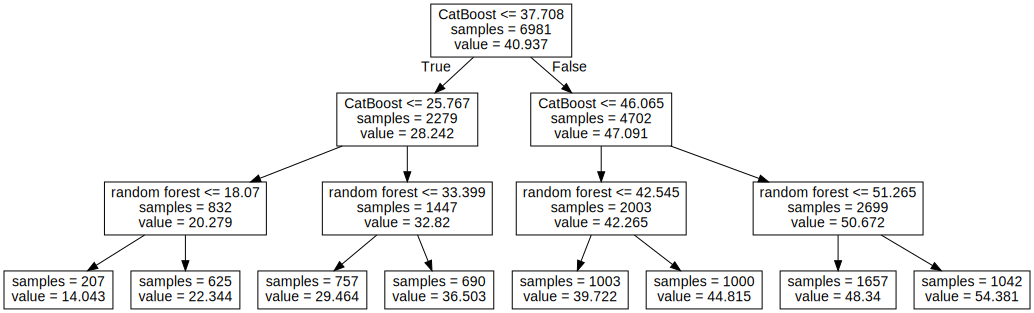

In [61]:
import graphviz
dot = export_graphviz(
        tree_model,
        out_file=None,
        feature_names=feature_names,
        impurity=False,
    )
graph = graphviz.Source(dot)
graph


Although the performance of a stacking model with a decision tree as the final estimator is lower than logistic regression as the final estimator, they seems to agree that random forest is the most trustworthy model. The first split is on the random forest followed by XGBoost and LightGBM. 

<br><br>

## 4. Tree-based models with all features <a name="4"></a>
<hr>

### 4.1 Different models with all features

In [62]:
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pipe_lr_all = make_pipeline(preprocessor_all, Ridge(random_state=123))
pipe_rf_all = make_pipeline(preprocessor_all, RandomForestRegressor(random_state=123))
pipe_xgb_all = make_pipeline(preprocessor_all, XGBRegressor(random_state=123))
pipe_lgbm_all = make_pipeline(preprocessor_all, LGBMRegressor(random_state=123))
pipe_catboost_all = make_pipeline(
    preprocessor_all, CatBoostRegressor(verbose=0, random_state=123)
)

models = {
    "ridge_all": pipe_lr_all,
    "random forest_all": pipe_rf_all,
    "XGBoost_all": pipe_xgb_all,
    "LightGBM_all": pipe_lgbm_all,
    "CatBoost_all": pipe_catboost_all,
}

In [63]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

In [64]:
pd.DataFrame(results).T

,fit_time,score_time,test_neg RMSE,train_neg RMSE,test_r2,train_r2,test_mape,train_mape
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),-18.105 (+/- 0.329),-18.102 (+/- 0.083),-0.002 (+/- 0.001),0.000 (+/- 0.000),-193.549 (+/- 16.812),-193.505 (+/- 3.874)
ridge,0.038 (+/- 0.033),0.025 (+/- 0.027),-15.873 (+/- 0.327),-15.840 (+/- 0.081),0.230 (+/- 0.021),0.234 (+/- 0.005),-161.321 (+/- 13.786),-160.987 (+/- 3.134)
random forest,4.187 (+/- 0.041),0.043 (+/- 0.001),-14.813 (+/- 0.414),-5.571 (+/- 0.055),0.329 (+/- 0.027),0.905 (+/- 0.002),-137.900 (+/- 15.621),-50.632 (+/- 1.716)
XGBoost,0.720 (+/- 0.006),0.010 (+/- 0.000),-15.654 (+/- 0.355),-6.709 (+/- 0.210),0.251 (+/- 0.031),0.862 (+/- 0.010),-135.043 (+/- 16.195),-45.715 (+/- 1.986)
LightGBM,0.114 (+/- 0.001),0.012 (+/- 0.000),-14.939 (+/- 0.448),-10.917 (+/- 0.058),0.318 (+/- 0.031),0.636 (+/- 0.003),-135.424 (+/- 17.275),-92.692 (+/- 2.571)
CatBoost,2.732 (+/- 0.467),0.010 (+/- 0.002),-14.906 (+/- 0.337),-9.829 (+/- 0.116),0.321 (+/- 0.023),0.705 (+/- 0.006),-133.988 (+/- 15.170),-77.618 (+/- 2.485)
voting,6.458 (+/- 0.553),0.087 (+/- 0.008),-14.770 (+/- 0.393),-9.327 (+/- 0.065),0.333 (+/- 0.025),0.734 (+/- 0.004),-139.578 (+/- 15.429),-84.483 (+/- 2.031)
stacking,41.979 (+/- 2.187),0.090 (+/- 0.013),-14.704 (+/- 0.385),-8.453 (+/- 0.204),0.339 (+/- 0.024),0.782 (+/- 0.011),-137.780 (+/- 15.297),-75.670 (+/- 2.724)
ridge_all,0.119 (+/- 0.047),0.044 (+/- 0.039),-11.086 (+/- 0.236),-10.787 (+/- 0.057),0.624 (+/- 0.011),0.645 (+/- 0.003),-108.498 (+/- 12.845),-104.684 (+/- 1.949)
random forest_all,22.794 (+/- 1.264),0.072 (+/- 0.018),-10.615 (+/- 0.418),-3.907 (+/- 0.040),0.655 (+/- 0.024),0.953 (+/- 0.001),-87.912 (+/- 13.197),-31.122 (+/- 1.073)


After including categorical and text features, the scores are markedly better. So with better representation we are getting a better model. 
`CatBoost` and other tree-based ensemble models still seem to be performing the best but the scores of a linear model (`Ridge`) are also comparable.

<br><br>

### 4.2 True popularity vs predictions  

In [65]:
pipe_catboost_all.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['valence', 'speechiness',
                                                   'tempo', 'instrumentalness',
                                                   'acousticness',
                                                   'duration_ms', 'liveness',
                                                   'danceability', 'energy',
                                                   'loudness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

Text(0, 0.5, 'predicted popularity')

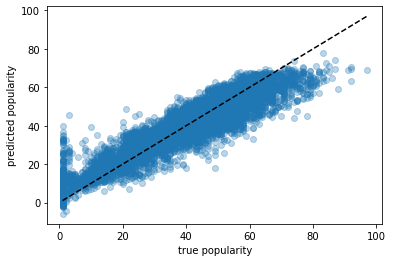

In [66]:
plt.scatter(y_train, pipe_catboost_all.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true popularity")
plt.ylabel("predicted popularity")

There seem to be some outliers on both sides but overall in the plot it seems like the model tends to underestimate the popularity. That said, when you look how often you overestimated vs. underestimated, it seems like we are overestimating. Probably we are not able to see it in the plot due to many overlapping points.  

In [67]:
predictions = pipe_catboost_all.predict(X_train)

In [68]:
np.mean(predictions > y_train)

0.5384615384615384

In [69]:
np.mean(predictions < y_train)

0.46153846153846156

<br><br>

### 4.3 Ridge coefficients

In [70]:
preprocessor_all.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['valence', 'speechiness', 'tempo',
                                  'instrumentalness', 'acousticness',
                                  'duration_ms', 'liveness', 'danceability',
                                  'energy', 'loudness']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['mode']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['genre', 'time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'tr

In [71]:
ohe_feats = (
    preprocessor_all.named_transformers_["onehotencoder-2"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

In [72]:
text_feats = (
    preprocessor_all.named_transformers_["countvectorizer"]
    .get_feature_names_out()
    .tolist()
)

In [73]:
feature_names = numeric_features + binary_features + ohe_feats + text_feats

In [74]:
pipe_lr = make_pipeline(preprocessor_all, Ridge())
pipe_lr.fit(X_train, y_train)

In [75]:
coefs = pipe_lr.named_steps["ridge"].coef_

In [76]:
data = {
    "coefficient": pipe_lr.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_lr.named_steps["ridge"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "coefficient", ascending=False
)
coef_df

,coefficient,magnitude
genre_Pop,24.488328,24.488328
genre_Rap,19.603993,19.603993
genre_Hip-Hop,18.411557,18.411557
genre_Rock,17.643133,17.643133
genre_Dance,15.162367,15.162367
...,...,...
genre_Ska,-12.964163,12.964163
genre_Anime,-16.606426,16.606426
genre_Opera,-22.140196,22.140196
genre_A Capella,-23.786890,23.786890


<br><br>

### 4.4 Random forest feature importances

In [77]:
pipe_rf_all = make_pipeline(preprocessor_all, RandomForestRegressor(random_state=123))
pipe_rf_all.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['valence', 'speechiness',
                                                   'tempo', 'instrumentalness',
                                                   'acousticness',
                                                   'duration_ms', 'liveness',
                                                   'danceability', 'energy',
                                                   'loudness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

In [78]:
data = {
    "Importance": pipe_rf_all.named_steps["randomforestregressor"].feature_importances_,
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)
imps.sort_values(by="Importance", ascending=False)[:10]

,Importance
acousticness,0.190423
genre_Movie,0.065080
genre_Pop,0.050687
duration_ms,0.043212
loudness,0.039726
genre_Rap,0.037525
genre_Children's Music,0.034911
liveness,0.032937
genre_Anime,0.032277
speechiness,0.032200


From the table above, **acousticness**, **genre_Movie**, **genre_Pop** seem to be driving the predictions the most. From the feature importances information we cannot really tell in which direction they are driving the predictions. Unlike `Ridge`, random forest feature importances do not have a sign, as they are not a linear model.  

<br><br>

## 5. SHAP <a name="5"></a>
<hr>

In [81]:
import shap

Let's first create encoded versions of `X_train` and `X_test` which we need to pass to SHAP.  

In [82]:
preprocessor_all.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['valence', 'speechiness', 'tempo',
                                  'instrumentalness', 'acousticness',
                                  'duration_ms', 'liveness', 'danceability',
                                  'energy', 'loudness']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['mode']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['genre', 'time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'tr

In [83]:
X_train_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,valence,speechiness,tempo,instrumentalness,acousticness,duration_ms,liveness,danceability,energy,loudness,...,talk,theme,time,tu,version,want,way,woman,world,young
57856,-1.489401,-0.459564,-1.088157,0.019905,1.728729,1.915608,0.763331,-1.880782,-1.300481,-0.490339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199801,-1.617463,-0.454588,-1.050155,2.535196,0.757986,-0.107807,-0.418076,-2.044577,-1.319524,-1.429502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85259,0.367119,-0.277668,-0.059624,-0.488400,-0.922102,-0.057213,0.666578,0.074193,0.885676,0.741946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181482,1.502909,-0.021687,0.172648,-0.488373,-0.586985,-0.029608,-0.617693,0.623699,1.201792,0.376336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220736,-1.104071,-0.428050,0.330176,-0.488400,0.805820,1.271067,-0.265308,-1.315424,0.295337,0.589789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's create encoded test data.  

In [84]:
X_test_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,valence,speechiness,tempo,instrumentalness,acousticness,duration_ms,liveness,danceability,energy,loudness,...,talk,theme,time,tu,version,want,way,woman,world,young
116505,0.168928,0.011486,1.162373,-0.488400,-0.707976,-0.418542,-0.775554,1.152071,0.101097,0.563734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147921,0.058398,-0.195842,-0.672721,0.947972,-1.011298,-0.771418,-0.504645,0.016072,0.596219,0.316876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229940,1.003619,-0.470621,0.132193,-0.486905,-0.785917,-0.313561,0.233735,1.041113,0.737139,0.827628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107239,-1.115505,-0.316922,0.699410,-0.488145,1.734357,0.165647,-0.717502,-0.787053,-1.809314,-1.770727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102112,-0.642895,-0.487760,0.193473,-0.488294,-0.333747,-0.151975,-0.351877,-0.126588,0.139183,0.629707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
pipe_lgbm_all.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['valence', 'speechiness',
                                                   'tempo', 'instrumentalness',
                                                   'acousticness',
                                                   'duration_ms', 'liveness',
                                                   'danceability', 'energy',
                                                   'loudness']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                                                  ['mode']),
                                                 ('onehotencoder-2',
                       

In [86]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm_all.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [87]:
# We are only extracting shapely values for the first 100 test examples for speed.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [88]:
test_lgbm_shap_values.shape

(100, 153)

In [89]:
train_lgbm_shap_values.shape

(6981, 153)

<br><br>

### 5.1 SHAP summary plots

#### Summary plots

In [90]:
shap.initjs()

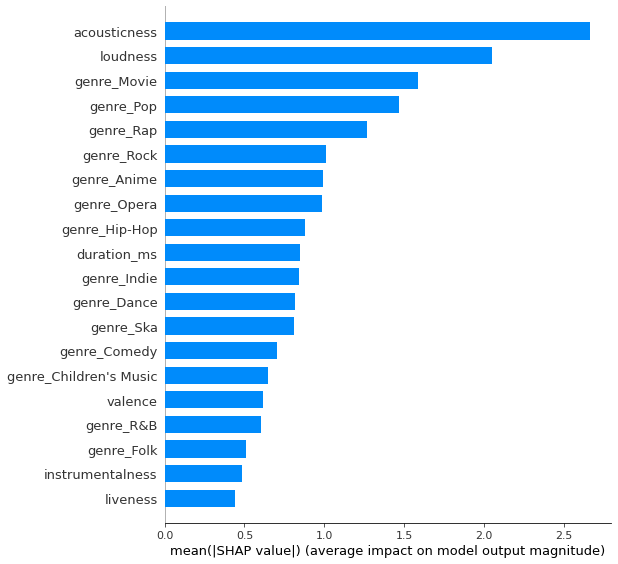

In [91]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

SHAP feature importance is measured as the mean absolute Shapley values. The plot above shows how much a feature will change the prediction.

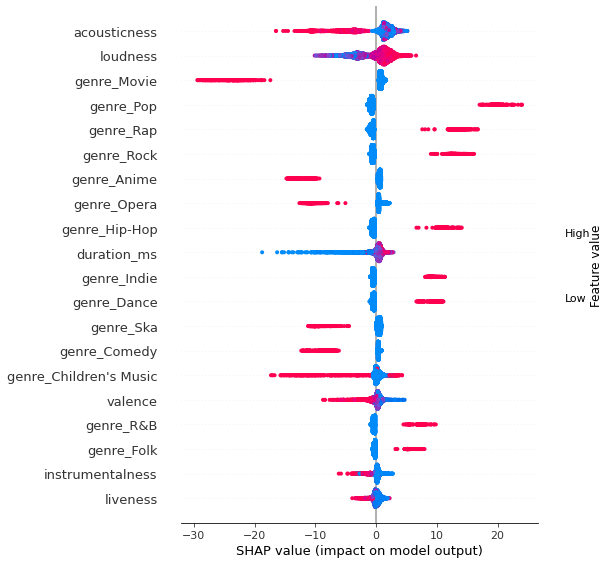

In [92]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc)

- The first plot shows global feature importances whereas the second one shows local feature importances. 
- The features are ranked in descending order of feature importances. 
- Colour shows the value of feature (red for a higher value and blue for a lower value)
- Many genre features are also showing up as most important features. 
- Higher SHAP value is associated higher popularity and smaller SHAP value means smaller value for popularity. 
- High values for acousticness seems to have a negative impact on popularity prediction whereas high values for loudness seem to have a positive impact on popularity prediction. 
- Other features which seem to have a negative impact on popularity prediction are:
    - genre_Movie
    - genre_Children Music
    - genre_Opera
    - genre_Comedy    
- Other features which seem to have a positive impact on popularity prediction are:    
    - genre_Pop
    - genre_Rap
    - genre_Rock    
    - genre_Hip hop    


<br><br>

### 5.3 SHAP force plots

For better display of the force plot, let's round off feature values. 

In [93]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

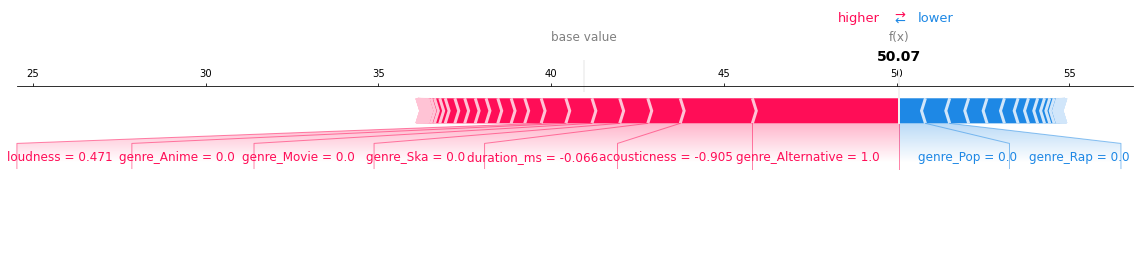

In [94]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[8],
    X_test_enc.iloc[8, :],
    matplotlib=True,
)

The prediction is the popularity = 1, which means it is popular, because f(x) is larger than base value. Alternative contributes the most in this case, followed by acousticness.

In [95]:
test_lgbm_shap_values[8].sum() + lgbm_explainer.expected_value

50.06917412770532

In [96]:
y_test.iloc[8]

50

The prediction is close to the true popularity value.

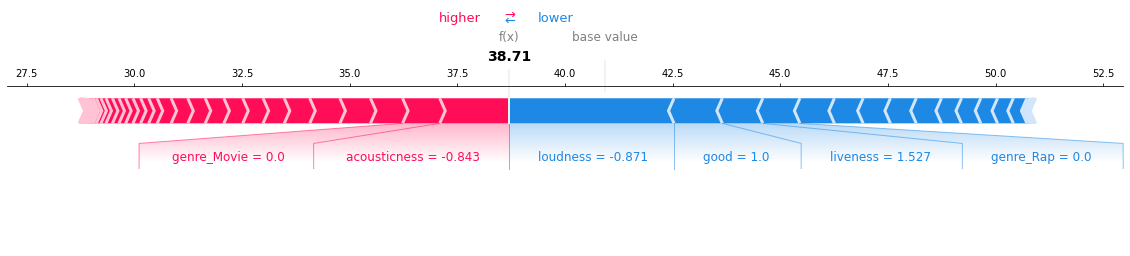

In [97]:
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[6],
    X_test_enc.iloc[6, :],
    matplotlib=True,
)

The prediction is the popularity = 0, which means it is not popular, because f(x) is less than base value. Loudness contributes the most in this case, followed by acousticness.

In [98]:
test_lgbm_shap_values[6].sum() + lgbm_explainer.expected_value

38.70836346482844

In [99]:
y_test.iloc[6]

41

The prediction is close to the true popularity value, since 38.7 is close to 41.

In [100]:
lgbm_explainer.expected_value

40.93740151785264

- In the plots above we see the forces that drive the prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue. 
- In this particular case, the base prediction (average over the dataset) is 40.94. 
- In the first example, the prediction is greater than the expected value. So the popularity is higher than average according to the model. Some of the forces driving the prediction towards higher value are: 
    - presence of genre_Alternative 
    - a negative value for acousticness
    - a positive value for loudness
    - a negative value for duration_ms
    - absence of genre_Ska, genre_Movie, and genre_Anime
- In the second example, the prediction is smaller than the expected value. So the popularity is going to be lower than average according to the model. Some of the forces driving the prediction towards smaller value are:
    - a negative value for loudness 
    - a positive value for liveliness
    - absence of the genre genre_Rap
    - presence of the word "good" in the track name (interesting!)
- The predictions close to the true popularity values. 